In [1]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
import subprocess
from glob import glob
from pkg import *
from pkg.functions import convert2int, convert2str, get_params
from typing import List, Dict, Any

In [2]:
datasets = [1, 4]

myPaths = path.PathManager(datasets=datasets)
myProcessor = process.Processor(paths=myPaths, datasets=datasets)
params = myProcessor.get_parameters()
print(params)
f.get_counts(paths=myPaths, datasets=datasets)

# myDatasetManager = data.DatasetManager(paths=myPaths, datasets=datasets)

# train_loader, test_loader = f.prepare(data_manager=myDatasetManager, batch_size=10)

peaks : ['c:\\Users\\eseveret\\Desktop\\cxls_hitfinder\\images\\peaks\\01\\empty_peak_01_00001.h5', 'c:\\Users\\eseveret\\Desktop\\cxls_hitfinder\\images\\peaks\\01\\empty_peak_01_00002.h5', 'c:\\Users\\eseveret\\Desktop\\cxls_hitfinder\\images\\peaks\\01\\empty_peak_01_00003.h5', 'c:\\Users\\eseveret\\Desktop\\cxls_hitfinder\\images\\peaks\\01\\empty_peak_01_00004.h5', 'c:\\Users\\eseveret\\Desktop\\cxls_hitfinder\\images\\peaks\\01\\empty_peak_01_00005.h5', 'c:\\Users\\eseveret\\Desktop\\cxls_hitfinder\\images\\peaks\\01\\empty_peak_01_00006.h5', 'c:\\Users\\eseveret\\Desktop\\cxls_hitfinder\\images\\peaks\\01\\empty_peak_01_00007.h5', 'c:\\Users\\eseveret\\Desktop\\cxls_hitfinder\\images\\peaks\\01\\empty_peak_01_00008.h5', 'c:\\Users\\eseveret\\Desktop\\cxls_hitfinder\\images\\peaks\\01\\empty_peak_01_00009.h5', 'c:\\Users\\eseveret\\Desktop\\cxls_hitfinder\\images\\peaks\\01\\empty_peak_01_00010.h5', 'c:\\Users\\eseveret\\Desktop\\cxls_hitfinder\\images\\peaks\\01\\empty_peak_01_0

In [3]:
f.check_attributes(paths=myPaths, datasets=f.convert2str(datasets), dir_type='peak')
print(myProcessor.get_parameters())

f.retrieve_attributes(file_path=myPaths.total_paths.water_background[0])

c:\Users\eseveret\Desktop\cxls_hitfinder\images\peaks\01\empty_peak_01_00001.h5 conforms to expected attributes.
c:\Users\eseveret\Desktop\cxls_hitfinder\images\peaks\01\empty_peak_01_00001.h5:
Expected Peak: False, Actual Peak: False
c:\Users\eseveret\Desktop\cxls_hitfinder\images\peaks\01\empty_peak_01_00002.h5 conforms to expected attributes.
c:\Users\eseveret\Desktop\cxls_hitfinder\images\peaks\01\empty_peak_01_00002.h5:
Expected Peak: False, Actual Peak: False
c:\Users\eseveret\Desktop\cxls_hitfinder\images\peaks\01\empty_peak_01_00003.h5 conforms to expected attributes.
c:\Users\eseveret\Desktop\cxls_hitfinder\images\peaks\01\empty_peak_01_00003.h5:
Expected Peak: False, Actual Peak: False
c:\Users\eseveret\Desktop\cxls_hitfinder\images\peaks\01\empty_peak_01_00004.h5 conforms to expected attributes.
c:\Users\eseveret\Desktop\cxls_hitfinder\images\peaks\01\empty_peak_01_00004.h5:
Expected Peak: False, Actual Peak: False
c:\Users\eseveret\Desktop\cxls_hitfinder\images\peaks\01\emp

{'clen': 0.15, 'peak': False, 'photon_energy': 6000}

In [4]:
f.get_counts(paths=myPaths, datasets=datasets)
# %run process_directory.py ../../images  --percent_empty 0.5 
# f.get_counts(paths=myPaths, datasets=datasets)

peaks : ['c:\\Users\\eseveret\\Desktop\\cxls_hitfinder\\images\\peaks\\01\\empty_peak_01_00001.h5', 'c:\\Users\\eseveret\\Desktop\\cxls_hitfinder\\images\\peaks\\01\\empty_peak_01_00002.h5', 'c:\\Users\\eseveret\\Desktop\\cxls_hitfinder\\images\\peaks\\01\\empty_peak_01_00003.h5', 'c:\\Users\\eseveret\\Desktop\\cxls_hitfinder\\images\\peaks\\01\\empty_peak_01_00004.h5', 'c:\\Users\\eseveret\\Desktop\\cxls_hitfinder\\images\\peaks\\01\\empty_peak_01_00005.h5', 'c:\\Users\\eseveret\\Desktop\\cxls_hitfinder\\images\\peaks\\01\\empty_peak_01_00006.h5', 'c:\\Users\\eseveret\\Desktop\\cxls_hitfinder\\images\\peaks\\01\\empty_peak_01_00007.h5', 'c:\\Users\\eseveret\\Desktop\\cxls_hitfinder\\images\\peaks\\01\\empty_peak_01_00008.h5', 'c:\\Users\\eseveret\\Desktop\\cxls_hitfinder\\images\\peaks\\01\\empty_peak_01_00009.h5', 'c:\\Users\\eseveret\\Desktop\\cxls_hitfinder\\images\\peaks\\01\\empty_peak_01_00010.h5', 'c:\\Users\\eseveret\\Desktop\\cxls_hitfinder\\images\\peaks\\01\\empty_peak_01_0

In [23]:
myDataManager = data.DatasetManager(paths=myPaths, datasets=datasets, transform=None)

# peak, label, overlay are valid types
# clen, photon_energy = myProcessor.get_parameters()

# f.check_attributes(paths=myPaths, dataset=datasets, type='peak', clen=clen, photon_energy=photon_energy) 
# f.check_attributes(paths=myPaths, dataset=datasets, type='overlay', clen=clen, photon_energy=photon_energy)
# f.check_attributes(paths=myPaths, dataset=datasets, type='label', clen=clen, photon_energy=photon_energy)

train_loader, test_loader = f.prepare(data_manager=myDataManager, batch_size=15)

peaks : ['c:\\Users\\eseveret\\Desktop\\cxls_hitfinder\\images\\peaks\\01\\empty_peak_01_00001.h5', 'c:\\Users\\eseveret\\Desktop\\cxls_hitfinder\\images\\peaks\\01\\empty_peak_01_00002.h5', 'c:\\Users\\eseveret\\Desktop\\cxls_hitfinder\\images\\peaks\\01\\empty_peak_01_00003.h5', 'c:\\Users\\eseveret\\Desktop\\cxls_hitfinder\\images\\peaks\\01\\empty_peak_01_00004.h5', 'c:\\Users\\eseveret\\Desktop\\cxls_hitfinder\\images\\peaks\\01\\empty_peak_01_00005.h5', 'c:\\Users\\eseveret\\Desktop\\cxls_hitfinder\\images\\peaks\\01\\empty_peak_01_00006.h5', 'c:\\Users\\eseveret\\Desktop\\cxls_hitfinder\\images\\peaks\\01\\empty_peak_01_00007.h5', 'c:\\Users\\eseveret\\Desktop\\cxls_hitfinder\\images\\peaks\\01\\empty_peak_01_00008.h5', 'c:\\Users\\eseveret\\Desktop\\cxls_hitfinder\\images\\peaks\\01\\empty_peak_01_00009.h5', 'c:\\Users\\eseveret\\Desktop\\cxls_hitfinder\\images\\peaks\\01\\empty_peak_01_00010.h5', 'c:\\Users\\eseveret\\Desktop\\cxls_hitfinder\\images\\peaks\\01\\empty_peak_01_0

In [6]:
file1 = '../../images/peaks/01/img_6keV_clen01_00137.h5'
file2 = '../../images/peaks/04/img_6keV_clen02_00176.h5'
print(f.retrieve_attributes(file1))
print(f.retrieve_attributes(file2))
# help(f.retrieve_attributes)

{'clen': 0.15, 'peak': True, 'photon_energy': 6000}
{'clen': 0.25, 'peak': True, 'photon_energy': 6000}


In [7]:
# for inputs, labels, attributes in train_loader:
#     print(attributes)

In [8]:
# f.check_attributes(paths=myPaths, dataset=datasets, type='peak', clen=clen, photon_energy=photon_energy)
# test_path = myPaths.get_peak_image_paths(datasets)[0]
# test = f.retrieve_attributes(test_path) 
# print(test)

In [9]:
# dir(m)

In [34]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# device = torch.device("cpu")
print(device)

model1 = m.Multi_Class_CNN1().to(device)
# model1 = m.BasicCNN3().to(device)
# criterion = nn.BCEWithLogitsLoss()
class_weights = f.get_counts_weights(paths=myPaths, datasets=datasets, classes=3).to(device)
print(class_weights)
# criterion = nn.CrossEntropyLoss(weight=class_weights)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model1.parameters(), lr=0.00001)

feature = 'clen'

cfg = {
    'num_epochs': 10,
    'num_classes': 3,
    'batch_size': train_loader.batch_size,
    'test_size': len(train_loader.dataset),
    'test_size': len(test_loader.dataset),
    'criterion': criterion,
    'optimizer': optimizer,
    'device': device,
    'model': model1,
    'threshold': 0.5
    }

labels = {
    'peaks': ["True", "False"],
    'photon_energy': [1,2,3],
    'clen': [1,2,3]
}

# # arguments: self, model, loader: list, criterion, optimizer, device, cfg: dict
t = train_eval.TrainTestModels(model=model1, loader=[train_loader, test_loader], criterion=criterion, optimizer=optimizer, device=device, cfg=cfg, feature=feature, labels=labels[feature])

cuda
peaks : ['c:\\Users\\eseveret\\Desktop\\cxls_hitfinder\\images\\peaks\\01\\empty_peak_01_00001.h5', 'c:\\Users\\eseveret\\Desktop\\cxls_hitfinder\\images\\peaks\\01\\empty_peak_01_00002.h5', 'c:\\Users\\eseveret\\Desktop\\cxls_hitfinder\\images\\peaks\\01\\empty_peak_01_00003.h5', 'c:\\Users\\eseveret\\Desktop\\cxls_hitfinder\\images\\peaks\\01\\empty_peak_01_00004.h5', 'c:\\Users\\eseveret\\Desktop\\cxls_hitfinder\\images\\peaks\\01\\empty_peak_01_00005.h5', 'c:\\Users\\eseveret\\Desktop\\cxls_hitfinder\\images\\peaks\\01\\empty_peak_01_00006.h5', 'c:\\Users\\eseveret\\Desktop\\cxls_hitfinder\\images\\peaks\\01\\empty_peak_01_00007.h5', 'c:\\Users\\eseveret\\Desktop\\cxls_hitfinder\\images\\peaks\\01\\empty_peak_01_00008.h5', 'c:\\Users\\eseveret\\Desktop\\cxls_hitfinder\\images\\peaks\\01\\empty_peak_01_00009.h5', 'c:\\Users\\eseveret\\Desktop\\cxls_hitfinder\\images\\peaks\\01\\empty_peak_01_00010.h5', 'c:\\Users\\eseveret\\Desktop\\cxls_hitfinder\\images\\peaks\\01\\empty_peak

Model testing and validating: Multi_Class_CNN1
Looking for the feature: clen
-- epoch 0
Train loss: 0.7282810636929103
Train accuracy: 0.5428571701049805
Test loss: 0.06897019942601522
Test accuracy: 1.2592592239379883
-- epoch 1
Train loss: 0.39975063289914814
Train accuracy: 0.8857142925262451
Test loss: 0.05008700887362162
Test accuracy: 1.2592592239379883
-- epoch 2
Train loss: 0.23537859533514296
Train accuracy: 0.8476190567016602
Test loss: 0.03636861145496369
Test accuracy: 2.0
-- epoch 3
Train loss: 0.16467168927192688
Train accuracy: 1.0
Test loss: 0.02714291016260783
Test accuracy: 2.0
-- epoch 4
Train loss: 0.10587332557354655
Train accuracy: 1.0
Test loss: 0.019212307532628377
Test accuracy: 2.0
-- epoch 5
Train loss: 0.07234925776720047
Train accuracy: 1.0
Test loss: 0.01578228423992793
Test accuracy: 2.0
-- epoch 6
Train loss: 0.05409378691443375
Train accuracy: 1.0
Test loss: 0.011356981098651886
Test accuracy: 2.0
-- epoch 7
Train loss: 0.04180806449481419
Train accurac

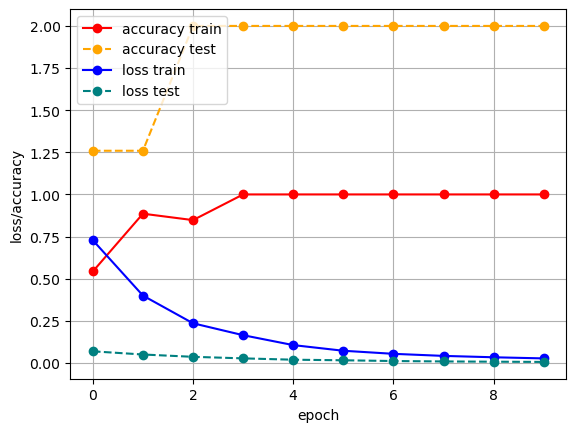

In [35]:
t.epoch_loop()
t.plot_loss_accuracy()

Labels: [1 1 1 1 1 1 2 1 2 2 1 1 1 1 2 2 1 1 1 2 1 2 2 1 1 2 2]
Predictions: [1 1 1 1 1 1 2 1 2 2 1 1 1 1 2 2 1 1 1 2 1 2 2 1 1 2 2]


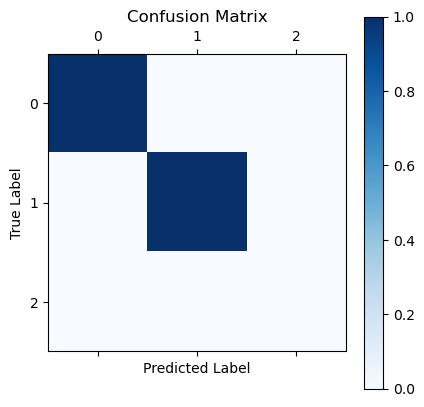

array([[1., 0., 0.],
       [0., 1., 0.],
       [0., 0., 0.]])

In [36]:
t.plot_confusion_matrix()
t.get_confusion_matrix()

In [13]:
# test_peaks = myPaths.get_peak_image_paths(dataset=dataset)[0]
# test_water = myPaths.get_peaks_water_overlay_image_paths(dataset=dataset)[0]
# test_overlay = myPaths.get_peaks_water_overlay_image_paths(dataset=dataset)[0]
# param1, param2 = (0.5, 9000), (0.5, 9000, True)
# f.assign_attributes(file_path=test_peaks, params=param1)

In [14]:
# t.save_model('../models/cnn3_test.pt')

In [15]:
# test_model = m.BasicCNN3()
# test_model.load_state_dict(torch.load('../models/cnn3_test.pt'))
# test_model.eval()


In [16]:
# for data, label, attribute in train_loader:
#     peak, _ = data
#     peak_image_attribute = attribute['peak']
#     output = test_model(peak)
#     print(peak_image_attribute)
#     print(torch.sigmoid(output).reshape(1,-1) > 0.5)
#     print('-------------------')

In [17]:
"""
How I want the new training input to look.

learning_rate = 0.001
threshold = 0.5
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

optimizer = optim.Adam(model1.parameters(), lr=learning_rate)

cfg = {
    "loader": [train_loader, test_loader]
    'num_epochs': 2,
    'batch_size': train_loader.batch_size,
    'optimizer': optimizer,
    'device': device,
    'threshold': threshold
    }

peak_config = eval.Peak_Detection_Configuration()

t = train_eval.TrainTestModels(cfg, peak_config)
t.epoch_loop()
t.plot_loss_accuracy()
t.plot_confusion_matrix()
t.get_confusion_matrix()
t.save_model('../models/cnn_name.pt')
"""

'\nHow I want the new training input to look.\n\nlearning_rate = 0.001\nthreshold = 0.5\ndevice = torch.device("cuda" if torch.cuda.is_available() else "cpu")\n\noptimizer = optim.Adam(model1.parameters(), lr=learning_rate)\n\ncfg = {\n    "loader": [train_loader, test_loader]\n    \'num_epochs\': 2,\n    \'batch_size\': train_loader.batch_size,\n    \'optimizer\': optimizer,\n    \'device\': device,\n    \'threshold\': threshold\n    }\n\npeak_config = eval.Peak_Detection_Configuration()\n\nt = train_eval.TrainTestModels(cfg, peak_config)\nt.epoch_loop()\nt.plot_loss_accuracy()\nt.plot_confusion_matrix()\nt.get_confusion_matrix()\nt.save_model(\'../models/cnn_name.pt\')\n'

In [18]:
"""
How I want the pipeline to look.

cnn1_path = '../models/cnn1'
cnn2_path = '../models/cnn2'
cnn3_path = '../models/cnn3'

cnn1 = m.BasicCNN1()
cnn2 = m.BasicCNN2()
cnn3 = m.BasicCNN3()

pipeline = pipe.ModelPipeline(cnn1_path, cnn2_path, cnn3_path, cnn1, cnn2, cnn3)
pipeline.run(image)
pipeline.evaluate_results(image_path)
"""

"\nHow I want the pipeline to look.\n\ncnn1_path = '../models/cnn1'\ncnn2_path = '../models/cnn2'\ncnn3_path = '../models/cnn3'\n\ncnn1 = m.BasicCNN1()\ncnn2 = m.BasicCNN2()\ncnn3 = m.BasicCNN3()\n\npipeline = pipe.ModelPipeline(cnn1_path, cnn2_path, cnn3_path, cnn1, cnn2, cnn3)\npipeline.run(image)\npipeline.evaluate_results(image_path)\n"